Guillaume Chaslot <guillaume.chaslot@data.gouv.fr>

# Tax Law Simplifier

The tax law is more than 200,000 lines long and opaque.

We believe that with this tool, *you* can make it less than 100 lines, transparent, and 99% similar to the existing legislation

### How it works:

1. Define your concepts (e.g., 'nb_enfants', 'age', 'parent isolé') and budget (e.g.: save 50,000,000 euros)
2. The machine learning algorithm helps you adjust the parameters of your reform to approximate the current legislation and fit your budget
3. From the biggest discrepencies with the current legislation, you can improve your concepts (or the legislation)
4. Repeat until you reach a legislation that matches your own goals. The algorithm takes care of minimizing your budget and maximizing the similarity to current legislation.

### Results:

Within a few minutes it is possible to run tens of iteration.

### Beta version limitations:

For this test, we only take a population of people from all ages, who have 0 to 5 children, no salary, married, veuf, paces, divorces or celibataires, and simulate the "aides sociales"


In [11]:
from compare_simulators import CalculatorComparator
from population_simulator import CerfaPopulationSimulator
from utils import show_histogram
from utils import percent_diff
from utils import scatter_plot

import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

# Load the population data

The population data is simulated for now, see population_simulator.py for details. Just do it.

In [12]:
comp = CalculatorComparator()
comp.load_openfisca_from_json('1aj-1bj-f-2000')

revdisp = comp.get_variable_from_openfisca('revdisp')

# Extract the concepts of interest

You can add concepts here if you like. The input population is in the CERFA declaration des revenus format.

In [13]:
population = []
original_index = []

def cas_improbable(case):
    # It is highly unlikely to have enfants a charge above 64 so we remove those cases
    if (int(case['0DA']) <= 1950 or ('0DB' in case and int(case['0DA'] <= 1950))) and 'F' in case and int(case['F']) > 0:
        return True
    return False

for i in range(0, len(comp.testcases)):
    case = comp.testcases[i]
    if case.get('1AJ', 0) < 1 and case.get('1BJ', 0) < 1 and not cas_improbable(case):
        original_index.append(i)
        new_family = {}
        new_family['taxable_income'] =  case.get('1AJ', 0)
        new_family['revdisp'] = revdisp[i]

        if 'F' in case:
            if case['F'] == 1:
                new_family['enfant_unique'] = 1
            if case['F'] >= 2:
                new_family['enfants_deux_ou_plus'] = 1
            if case['F'] > 2:
                new_family['nb_enfants_au_dessus_de_2'] = case['F'] - 2
            new_family['nb_enfants'] = case['F']

        if 'O' in case or 'M' in case:
            new_family['two_people'] = 1                

        one_declarant_above_24 = False
        both_declarant_parent_below_24 = 'F' in case

        if '0DA' in case:
            age_1 = 2014 - case['0DA']
            new_family['age-dec1'] = age_1
#             if age <= 24 and 'F' in case:
#                 new_family['declarant parent <= 24 ans'] = 1
            if age_1  >= 24:
                one_declarant_above_24 = True
                both_declarant_parent_below_24 = False
#                 new_family['declarant > 24 ans'] = 1
            if age_1  > 64:
                new_family['declarant > 64 ans'] = 1
                new_family['declarants > 64 ans'] = 1

        age_2 = 0            
        if '0DB' in case:
            age_2 = 2014 - case['0DB']
            new_family['age-dec2'] = age_2
            if age_2  >= 24:
                one_declarant_above_24 = True
                both_declarant_parent_below_24 = False

#                 new_family['codeclarant > 24 ans'] = 1
            if age_2  > 64:
                new_family['declarants > 64 ans'] = new_family.get('declarants > 64 ans', 0) + 1
                new_family['codeclarant > 64 ans'] = 1

        if age_1 >= 24 and age_2 >= 24:
            new_family['both > 24 ans'] = 1

        if both_declarant_parent_below_24:
            new_family['both_declarant_parent_below_24'] = True
            
        if one_declarant_above_24:
            new_family['one_declarant_above_24'] = True

        if 'F' in case and ('C' in case or 'D' in case or 'V' in case):
            new_family['parent_isolé'] = True
            
        if 'F' in case and ('M' in case or 'O' in case):
            new_family['parents_en_couple'] = True

        population.append(new_family)

print 'Number of family: ' + repr(len(population))

total_people = 0
for family in comp.testcases:
    total_people += 1
    if '0DB' in family and family['0DB'] == 1:
        total_people += 1
    if 'F' in family:
        total_people += family['F']

# We assume that there are 2000000 people with RSA
echantillon =  float(total_people) / 2000000
print 'Echantillon of ' + repr(total_people) + ' people, in percent of french population for similar revenu: ' + repr(100 * echantillon) + '%'


Number of family: 742
Echantillon of 2863 people, in percent of french population for similar revenu: 0.14315%


# Plots Revenu disponible before reform

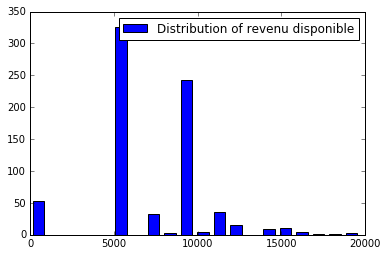

In [14]:
revdisp_when_no_salary = list(family['revdisp'] for family in population)

show_histogram(revdisp_when_no_salary, 'Distribution of revenu disponible')

# Define your reform here

Give all the concepts you care about either as:

* <strong> boolean parameters</strong> can be either 1, or 0, or missing (e.g., one_declarant_above_24)


* <strong> linear parameters </strong> can be floats (e.g., nb_enfants)


* <strong> segmentation parameters </strong> are segmented by the algorithm into several boolean parameters (e.g., age_declarant_principal might be broken down automatically by the algo into 0-25 / 25-64 / 65+)

In [ ]:
from reformators import Excalibur

sword = Excalibur(population, 'revdisp', 'taxable_income', echantillon=echantillon)

simulated_reform = sword.suggest_reform(
                           boolean_parameters = ['both_declarant_parent_below_24'],
                           linear_parameters = ['nb_enfants'],
                           barem_parameters = ['age-dec1', 'age-dec2'],
                           save=0)

# Plots revenu disponible after reform

In [ ]:
xmin = 4900
xmax = 19000
nb_buckets = 25

bins = np.linspace(xmin, xmax, nb_buckets)

plt.hist(revdisp_when_no_salary, bins, alpha=0.5, label='current')
plt.hist(simulated_reform, bins, alpha=0.5, label='reform')
plt.legend(loc='upper right')
plt.show()

# Distribution of the changes in revenu in euros

In [ ]:
difference = list(simulated_reform[i] - revdisp_when_no_salary[i] for i in range(len(simulated_reform)))

show_histogram(difference, 'Changes in revenu')

# Distribution of the change in revenu in percentage

In [ ]:
percentage_difference = list(100 * percent_diff(simulated_reform[i], revdisp_when_no_salary[i]) for i in range(len(simulated_reform)))

show_histogram(percentage_difference, 'Changes in revenu')

# Change as a function of the number of children

In [ ]:
nb_children = list((population[i].get('nb_enfants', 0)  for i in range(len(population)))) 

scatter_plot(nb_children, difference, 'Age declarant 1', 'Difference reform - current', alpha=0.01)

# Change as a function of the age of declarant 1

A scatter plot is better than a thousand points #ChineseProverb

In [ ]:
age_dec1 = list((population[i].get('age-dec1', 0)  for i in range(len(population)))) 

scatter_plot(age_dec1, difference, 'Age declarant 1', 'Difference reform - current', alpha=0.1)

# Most important: Edge Cases

This is the heart of this tool: by seeing the worse cases, you can discover when the current legislation is smarter than yours (or the other way), and improve it further

In [ ]:
# TODO: also give the detail of the calculus both for Openfisca and the Reform

original_population = []
original_revdisp = []
for i in range(0, len(population)):
    original_population.append(comp.testcases[original_index[i]])
    original_revdisp.append(revdisp[original_index[i]])

order = sorted(range(len(simulated_reform)), key=lambda k: -abs(simulated_reform[k] - revdisp_when_no_salary[k]))

for i in order:
    print 'Case ' + repr(original_population[i]) + ' Current =' + repr(int(revdisp_when_no_salary[i])) + ' Reform = ' + repr(int(simulated_reform[i]))

# Best compromise simplicity / matching current legislation:

In [ ]:
sword = Excalibur(population,'revdisp', 'taxable_income', echantillon=echantillon)
res = sword.suggest_reform(boolean_parameters=[
                            'one_declarant_above_24',
                            'declarant > 64 ans',
                            'codeclarant > 64 ans',
                            'two_people',
                           ],
                           linear_parameters=['nb_enfants'],
                          save=0)

In [ ]:
original_population = []
original_revdisp = []
for i in range(0, len(population)):
    original_population.append(comp.testcases[original_index[i]])
    original_revdisp.append(revdisp[original_index[i]])

order = sorted(range(len(simulated_reform)), key=lambda k: -abs(simulated_reform[k] - revdisp_when_no_salary[k]))

for i in order:
    print 'Case ' + repr(original_population[i]) + ' Current =' + repr(int(revdisp_when_no_salary[i])) + ' Reform = ' + repr(int(simulated_reform[i]))

In [ ]:
from reformators import Excalibur

sword = Excalibur(population, 'revdisp', 'taxable_income', echantillon=echantillon)
simulated_reform = sword.suggest_reform(
                           boolean_parameters = ['both_declarant_parent_below_24', 'declarant > 64 ans', 'one_declarant_above_24', 'codeclarant > 64 ans'],
                           linear_parameters = ['nb_enfants'],
                           barem_parameters = [],
                           save=0)